In [1]:
import numpy as np 
import umap 
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from ripser import ripser
from persim import plot_diagrams

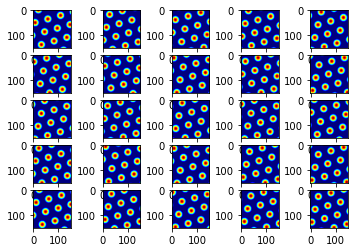

(1, 315, 150, 150)


In [2]:
def synth_grid(xx, yy, phase = 0, orientation = 0, f = 3):
    """ Create ratemaps for n synthetic grid cells
    params:
    xx, yy (np.ndarray): coordinate grids of shape (nx, ny)
    phase (np.array): phase shifts of shape (n,)
    orientation (float): orientation of grid cells. Shared by all n cells
    f (float): grid frequency
    """
    
    theta = np.array([i*np.pi/3 for i in range(3)]) + orientation
    kx = np.cos(theta)
    ky = np.sin(theta)
    
    x_phase = xx[None] + phase[:,0,None,None]
    y_phase = yy[None] + phase[:,1,None,None]
    inner_prod = kx[None,:,None,None]*x_phase[:,None] + ky[None,:,None,None]*y_phase[:,None]
    gc = np.clip(1/3*np.sum(np.cos(2*np.pi*f*inner_prod), axis = 1), 0, 1)
    return gc

def scatter3d(data, tags, ncols=4, nrows=4, s=1, alpha=0.5, azim_elev_title=True, **kwargs):
    assert data.shape[-1] == 3, "data must have three axes. No more, no less."
    if data.ndim > 2:
        data = data.reshape(-1, 3)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, subplot_kw={"projection": "3d"}, **kwargs)
    num_plots = ncols * nrows
    
    azims = np.linspace(0, 180, ncols + 1)[:-1]
    elevs = np.linspace(0, 90, nrows + 1)[:-1]

    view_angles = np.stack(np.meshgrid(azims, elevs), axis=-1).reshape(-1, 2)
    norm = matplotlib.colors.Normalize(np.amin(tags), np.amax(tags))
    color = matplotlib.cm.viridis(norm(tags))
    for i, ax in enumerate(axs.flat):
        ax.scatter(xs=data[:, 0], ys=data[:, 1], zs=data[:, 2], color=color, s=s, alpha=alpha)
        ax.azim = view_angles[i, 0]
        ax.elev = view_angles[i, 1]
        ax.axis("off")
        if azim_elev_title:
            ax.set_title(f"azim={ax.azim}, elev={ax.elev}")
    return fig, axs


def PCA_UMAP(states):
    """ Run PCA followed by UMAP on states; Similar to Gardner et al. (2022)
    
    states.shape = (Nsamples, Nfeatures)
    PCA down to 6 features/principal components 
    UMAP of PCA componenents to 3 features.
    
    Note: Gardner et al. use n_neighbors = 5000 (more than number of samples in our case...)
    """
    pca_fit = PCA(n_components = 6).fit(states)
    pca_result = pca_fit.transform(states)
    umap_fit = umap.UMAP(n_components = 3, min_dist = 0.8,  # Almost Gardner et al. params
                         n_neighbors = 1000, metric = "cosine", init = "spectral")
    umap_result = umap_fit.fit_transform(pca_result)
    return pca_result, umap_result
    
    
n = 150
x = np.linspace(0, 2.2, n) # Boxsize same as default
y = np.linspace(0, 2.2, n)
xx, yy = np.meshgrid(x,y)
# create modules
# each with unique random phases and orientations
n_envs = 1
n_mods = 1 # one for umap
cells_per_mod = 315
# every cell has a random phase
phases = np.random.uniform(-2, 2, (n_mods, cells_per_mod, 2))
# every module has a shared orientation
orientations = np.random.uniform(0, 2*np.pi, n_mods) # random orientation
# save resulting orientation
actual_orientations = np.zeros((n_envs, n_mods)) # save shifted orientations
# each module has a unique phase and orientation shift in each env.
phase_shifts = np.random.uniform(-4, 4, (n_envs, n_mods, 2))
orientation_shifts = np.zeros((n_envs, n_mods))#np.random.uniform(0, np.pi/3, (n_envs, n_mods))
synth_maps = np.zeros((n_envs, n_mods*cells_per_mod, n, n))
fs = [1.5 for i in range(n_mods)] # grid frequency the same for all (for now)

for i in range(n_envs):
    for j in range(n_mods):
        # cells per mod, 2 + None
        phase = phases[j] + phase_shifts[i,j][None] # modules phase shift coherently
        actual_orientations[i,j] =  orientations[j] + orientation_shifts[i,j] # and rotate coherently
        gc = synth_grid(xx, yy, phase, actual_orientations[i,j], f = fs[j]) # create ratemaps
        synth_maps[i,j*cells_per_mod: (j+1)*cells_per_mod] = gc # save module ratemap activity
# plot a random selection of cells         
env = 0
m = 5
fig, ax = plt.subplots(m, m)
for i in range(m**2):
    row = i // m
    col = i % m
    show = np.random.randint(synth_maps.shape[1])
    ax[row, col].imshow(synth_maps[env,show], cmap = "jet")
plt.show()

print(synth_maps.shape)

In [3]:
data = synth_maps[0].reshape((synth_maps.shape[1], -1)).T # ONLY ENV 0

fit = umap.UMAP(n_components = 3)
u = fit.fit_transform(data)

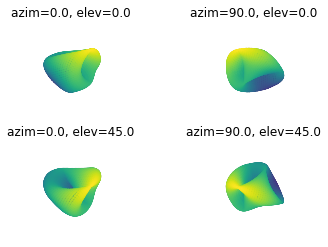

In [4]:
fig,axs = scatter3d(u,np.linalg.norm(u,axis=-1),nrows=2,ncols=2)#,azim_elev_title=False,figsize=figsize,s=0.005,alpha=0.8)

In [5]:
pca_fit, umap_fit = PCA_UMAP(data)

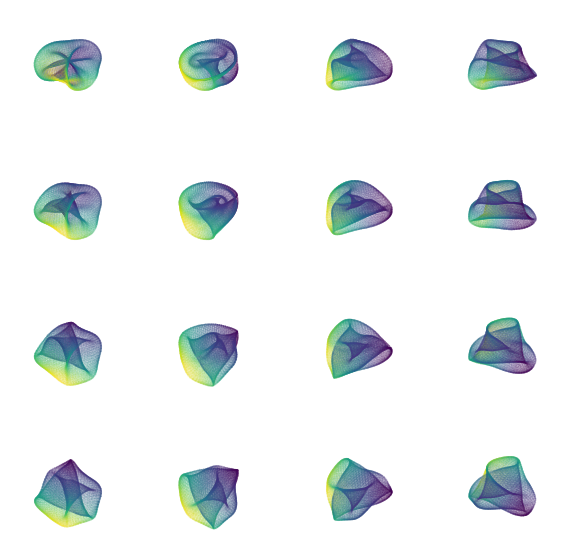

In [6]:
fig,axs = scatter3d(umap_fit, pca_fit[:,0],nrows=4,ncols=4,azim_elev_title=False,figsize=(10,10),s=0.005,alpha=0.8)

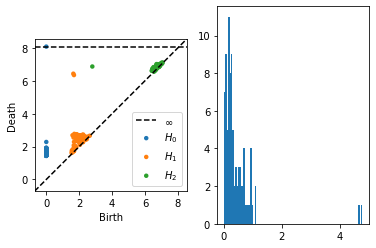

In [7]:
fig,axs = plt.subplots(ncols=2)
#dgms = ripser(g[env_i][:,module_indices],maxdim=2,n_perm=150)['dgms']
dgms = ripser(pca_fit,maxdim=2,n_perm=150)['dgms']
#dgms = ripser(umap_fit ,maxdim=2,n_perm=150)['dgms']
plot_diagrams(dgms, show=False, ax=axs[0])
_=axs[1].hist(dgms[1][:,1] - dgms[1][:,0], bins = 100)